In [1]:
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
from sortedcollections import SortedDict

# Building an INDRA interactome

Attempting to build a high quality INDRA interactome for network reconstruction tasks

## Loading Statements

I'm trying a new technique where successive transformations of a pandas dictionary are stored in a SortedDict

In [2]:
data = SortedDict()

In [3]:
data['dump'] = pd.read_pickle('../input/db_dump_091719.pkl')

We then filter to only statements where both agents have either a FamPlex or HGNC grounding

In [4]:
data['dump'].head()

,agA_ns,agA_id,agA_name,agB_ns,agB_id,agB_name,stmt_type,evidence_count,stmt_hash
0,HGNC,4013,FUT2,CHEBI,73579,Leu-Val,Activation,1,-21301812132397149
1,HGNC,12761,WEE1,HGNC,2498,CTDP1,Complex,1,21017369035451409
2,HGNC,2498,CTDP1,HGNC,12761,WEE1,Complex,1,21017369035451409
3,HGNC,2662,DAB2,HGNC,3796,FOS,DecreaseAmount,2,-18945642808758134
4,HGNC,8812,PDK4,FPLX,STAT5,STAT5,Inhibition,1,-13243120276770842


In [5]:
data['gene_stmts'] = data['dump'][((data['dump'].agA_ns == 'HGNC') | 
                                   (data['dump'].agA_ns == 'FPLX')) &
                                   ((data['dump'].agB_ns == 'HGNC') | 
                                    (data['dump'].agB_ns == 'FPLX'))].copy()

The belief scores are included in a separate pickle file. As are stratified evidence. The latter are used to filter to database only statements for database only interactomes

In [6]:
with open('../input/belief_dict_091719.pkl', 'rb') as f:
    belief = pickle.load(f)
with open('../input/db_stratified_evidence_091819.pkl', 'rb') as f:
    stratified_evidence = pickle.load(f)

This dictionary is keyed by hash. Let's add them as a column to gene_stmts_df

In [7]:
data['gene_stmts']['belief'] = data['gene_stmts'].stmt_hash.apply(lambda x: belief[x])
data['gene_stmts']['ev_strat'] = data['gene_stmts'].stmt_hash.apply(lambda x: stratified_evidence[x])

For on of our applications, we will be adding noise to edge weights. In OmicsIntegrator, edge weight values can be at most 0.99. It is problematic that belief scores cluster near 1, since additive noise will cause many weights to saturate at 0.99. We subtract a constant from belief scores to work around this. The specific value used is not important.

In [8]:
data['gene_stmts']['belief'] = data['gene_stmts']['belief'] - 0.1

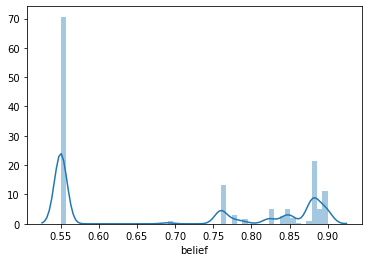

In [9]:
sns.distplot(data['gene_stmts'].belief)

Below we see the statements within our network. All of the different post-translational modifications as well as complexes should be included when building networks for running the temporal pathway synthesizer. One of its goals is to determine regulators of phosphorylation amoung different interactions beyond direct phosphorylation and dephosphorylation.
Conversion statements are problematic in this context and will be filtered out.

In [10]:
data['gene_stmts'].stmt_type.unique()

array(['Complex', 'DecreaseAmount', 'Inhibition', 'IncreaseAmount',
       'Activation', 'Phosphorylation', 'Demethylation',
       'Dephosphorylation', 'Acetylation', 'Sumoylation', 'Hydroxylation',
       'Methylation', 'Deubiquitination', 'Ubiquitination',
       'Deacetylation', 'Gef', 'Glycosylation', 'Deribosylation', 'Gap',
       'Desumoylation', 'Ribosylation', 'Dehydroxylation',
       'Deglycosylation', 'Palmitoylation', 'Farnesylation', 'Conversion',
       'Myristoylation', 'GtpActivation', 'Depalmitoylation',
       'Defarnesylation', 'Geranylgeranylation'], dtype=object)

In [11]:
data['relevant_type'] = data['gene_stmts'][(data['gene_stmts'].stmt_type != 
                                            'Conversion')].copy()

In [12]:
data['relevant_type'].head()

,agA_ns,agA_id,agA_name,agB_ns,agB_id,agB_name,stmt_type,evidence_count,stmt_hash,belief,ev_strat
1,HGNC,12761,WEE1,HGNC,2498,CTDP1,Complex,1,21017369035451409,0.55,{'reach': 1}
2,HGNC,2498,CTDP1,HGNC,12761,WEE1,Complex,1,21017369035451409,0.55,{'reach': 1}
3,HGNC,2662,DAB2,HGNC,3796,FOS,DecreaseAmount,2,-18945642808758134,0.76,{'reach': 2}
4,HGNC,8812,PDK4,FPLX,STAT5,STAT5,Inhibition,1,-13243120276770842,0.55,{'reach': 1}
5,HGNC,12435,TXN,HGNC,3059,HBEGF,Complex,1,31832599631814675,0.55,{'sparser': 1}


We now have to do some flattening. But first lets remove self edges since they have no role in steiner analysis

In [13]:
data['no_self'] = data['relevant_type'][(data['relevant_type'].agA_name !=
                                         data['relevant_type'].agB_name)].copy()

We only want one edge between any pair of agents. If there are conflicting directions between two agents, we place an undirected edge between these agents. If there is only one direction along with undirected complexes, assign the edge the given direction.

Let's combine name space and name into a single identifier so we an distinguish between HGNC entries and FPLX entries

In [14]:
df = data['no_self'].copy()
df['agent1'] = df.apply(lambda row: f'{row.agA_ns}:{row.agA_name}', axis=1)
df['agent2'] = df.apply(lambda row: f'{row.agB_ns}:{row.agB_name}', axis=1)

We use stratified evidence to determine which statements have support from databases

In [15]:
databases = set(['bel_lc', 'biogrid', 'cbn', 'hprd', 'pc11', 'phosphosite', 'signor', 'trrust'])

In [16]:
df['database'] = df.ev_strat.apply(lambda x: bool(databases & x.keys()))

In [17]:
data['final'] = df

We than drop all but the relevant columns

In [18]:
proto_interactome = data['final'][['agent1', 'agent2', 'stmt_type', 'belief', 'database']]

We flatten statements with the same agents in the same order by taking the max of the belief scores and concatenating statement types into a list

In [19]:
groups = proto_interactome.groupby(['agent1', 'agent2'], as_index=False)

In [20]:
flattened = groups.agg({'stmt_type': list, 'belief': max, 'database': max})

We create a new column that contains the agent strings sorted and concatenated, so we can check for pairs of statements with the same agents but in different directions

In [21]:
flattened['agents_sorted'] = flattened.apply(lambda row: '#'.join(sorted([row.agent1,
                                                                          row.agent2])),
                                            axis=1)

We also have a column for the agents concatenated in their original order

In [22]:
flattened['agents'] = flattened.apply(lambda row: '#'.join(tuple([row.agent1,
                                                                 row.agent2])),
                                      axis=1)

and then drop the columns agent1 and agent2 since they are no longer needed

In [23]:
flattened = flattened.drop(['agent1', 'agent2'], axis=1)

Complexes are undirected. All other statements are directed. If there is at least one directed statement for a given pair of agents in a given order we mark this edge as directed

In [24]:
flattened['pre_direction'] = flattened.stmt_type.apply(lambda x: 'U' if x == ['Complex']
                                                                  else 'D')

We make an edge undirected if there are directed edges pointing in each direction. To carry this out we first group by the column agents_sorted

In [25]:
groups = flattened.groupby('agents_sorted', as_index=False)

We then aggregate by concatenating predirection, stmt_type and agents into lists, and taking the max of belief

In [26]:
df = groups.agg({'pre_direction': list, 'stmt_type': list,
                 'agents': lambda x: x.iloc[0], 'belief': max,
                 'database': max})

and here is where only edges with a directed statement in one of two directions become directed, with others being undirected

In [27]:
df['direction'] = df.pre_direction.apply(lambda x: 'D' if x.count('D') == 1 else 'U')

Let's recreate separate columns for agent1 and agent2

In [28]:
df[['agent1', 'agent2']] = df.agents.apply(lambda x: pd.Series(x.split('#')))

We extract the relevant columns into an interactome which is saved for later use

In [29]:
interactome = df[['agent1', 'agent2', 'belief', 'direction']]

filter to database statements to create a database only interactome

In [31]:
db_only = df[df.database == True][['agent1', 'agent2', 'belief', 'direction']]

In [ ]:
interactome

In [ ]:
interactome.to_csv('../input/indra_interactome_091819.tsv', sep='\t', header=False, index=False)

In [32]:
db_only.to_csv('../input/indra_interactome_db_only_092319.tsv', sep='\t', header=False, index=False)

In [ ]:
[len(interactome), len(db_only)]

## Phosphorylation and Dephosphorylation Stmts

This pickle file contains jsons for all phosphorylation and dephosphorylation statements as of September 2019

In [ ]:
with open('../input/phospho_stmts.pkl', 'rb') as f:
    phospho_stmts = pickle.load(f)

In [ ]:
phospho_stmts[0]

Let's now put thes statements into a dataframe. We keep only statements where both agents have either an HGNC or FPLX grounding

In [ ]:
rows = []
for stmt in phospho_stmts:
    row = {}
    enz_refs = stmt['enz']['db_refs']
    sub_refs = stmt['sub']['db_refs']
    if 'FPLX' in enz_refs:
        row['agent1'] = f'FPLX:{enz_refs["FPLX"]}'
    elif 'HGNC' in enz_refs:
        name = stmt['enz']['name']
        row['agent1'] = f'HGNC:{name}'
    else:
        continue
    if 'FPLX' in sub_refs:
        row['agent2'] = f'FPLX:{sub_refs["FPLX"]}'
    elif 'HGNC' in enz_refs:
        name = stmt['sub']['name']
        row['agent2'] = f'HGNC:{name}'
    else:
        continue
    row['type'] = stmt['type']
    row['position'] = stmt.get('position')
    row['residue'] = stmt.get('residue')
    row['hash'] = stmt['matches_hash']
    rows.append(row)

phospho_df = pd.DataFrame(rows)

In [ ]:
len(phospho_df)

In [ ]:
phospho_df['stmt_hash'] = phospho_df.hash.apply(int)

We then add belief scores

In [ ]:
phospho_df['belief'] = phospho_df.stmt_hash.apply(lambda x: belief[x])

and subtract by a positive constant to avoid saturation when adding noise to edge weights

In [ ]:
phospho_df['belief'] = phospho_df.belief - 0.1

Get indicator of support from database

In [ ]:
database = data['final'][['stmt_hash', 'database']]

In [ ]:
phospho_df = phospho_df.merge(database, on='stmt_hash', how='left')

Stick the site into the agent identifiers for making site specific network

In [ ]:
phospho_df

In [ ]:
with_sites = phospho_df.dropna().copy()
with_sites['agent2'] = with_sites.apply(lambda row: f'{row.agent2}:{row.residue}:{row.position}', axis=1)

In [ ]:
with_sites['edge'] = with_sites.type.apply(lambda x: 'A' if x == 'Phosphorylation' else 'I')

In [ ]:
phospho_interactome_sites = with_sites[['agent1', 'agent2', 'belief', 'edge', 'database']]

In [ ]:
groups = phospho_interactome_sites.groupby(['agent1', 'agent2'], as_index=False)

In [ ]:
flattened = groups.agg({'belief': max, 'edge': list, 'database': max})

In [ ]:
flattened['edge'] = flattened.edge.apply(lambda x: 'A' if set(x) == set(['A'])
                                                       else 'I' if set(x) == set(['I'])
                                                       else 'N')

In [ ]:
flattened.drop('database', axis=1).to_csv('../input/phospho_interactome_with_sites_091819.tsv', sep='\t', header=False, index=False)

And once again, but db only

In [ ]:
flattened_db = flattened[flattened.database == True]

In [ ]:
flattened_db.drop('database', axis=1).to_csv('../input/phospho_interactome_with_sites_db_only_092319.tsv',
                                             sep='\t', header=False, index=False)

### Flatten across sites

In [ ]:
phospho_no_sites = phospho_df[['agent1', 'agent2', 'type', 'belief', 'database']]

In [ ]:
flattened_no_sites = phospho_no_sites.groupby(['agent1', 'agent2'],
                                              as_index=False).agg({'belief': max, 
                                                                   'type': list,
                                                                   'database': max})

In [ ]:
flattened_no_sites['edge'] = flattened_no_sites.type.apply(lambda x: 'A' if set(x) == set(['Phosphorylation'])
                                                                else 'I' if set(x) == set(['Dephosphorylation'])
                                                                else 'N')

In [ ]:
flat = flattened_no_sites[['agent1', 'agent2', 'belief', 'edge', 'database']]

We should still remove self edges

In [ ]:
df = phospho_interactome
df = df[df.agent1 != df.agent2]
phospho_interactome = df

In [ ]:
phospho_interactome = flat.drop('database', axis=1)

In [ ]:
phospho_interactome.to_csv('../input/phospho_interactome_091819.tsv', sep='\t', header=False, index=False)

In [ ]:
phospho_db = flat[flat.database == True].drop('database', axis=1)

In [ ]:
phospho_db.to_csv('../input/phospho_interactome_db_only_092319.tsv',
                  sep='\t', header=False, index=False)

In [36]:
df = pd.read_csv('../input/phospho_interactome_db_only_092319.tsv', sep='\t',
                 names=['agent1', 'agent2', 'belief', 'edge'])

In [38]:
df = df[['agent1', 'edge', 'agent2']]

In [39]:
df.to_csv('../input/indra_tps_prior_092319.tsv', sep='\t', header=False, index=False)